### NN Vector Pull for Direction

Oct 31 2023
TJ Kim

##### Summary
Load any NN model. Obtain layer by layer the unit direction vector (against vector of zeros). See if cosine similarity can be used as a metric to measure direction.

In [4]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [5]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [6]:
setting, num_user, experiment  = "FedAvg", 40, 'cifar100'

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user, experiment)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar100/240222_FedAvg200round_lr001/FAT/'
save_path_FedAvg = 'weights/cifar100/240222_FedAvg200round_lr001/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 39%|███▉      | 39/100 [00:00<00:00, 299.15it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:05<00:00,  6.70it/s]


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def matrix_cosine_similarity(mat1, mat2):
    vec1 = mat1.cpu().numpy().flatten()
    vec2 = mat2.cpu().numpy().flatten()
    return cosine_similarity([vec1], [vec2])[0][0]

def get_diff_NN( model1, model2, desired_keys):

    param_model1 = model1.state_dict()
    param_model2 = model2.state_dict()

    mag_norm_122 = []
    for key in desired_keys: #params_FAT:

        diff = param_model1[key] - param_model2[key]
        l2_norm = torch.norm(diff, p=2)

        mag_norm_122 += [diff/torch.norm(diff,p=2)]
    return mag_norm_122

def diff_cosine_similarity(diff, baseline, key_length):
    values_stored = np.zeros(key_length)

    for i in range(key_length):
        values_stored[i] = matrix_cosine_similarity(diff[i], baseline[i])

    return values_stored 

def get_adv_acc(aggregator, model, batch_size = 500, data_mode = "all", c_id = 0):
    num_clients = len(aggregator.clients)

    # Dataloader for datax
    data_x = []
    daniloader = clients[0].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)

    data_x = torch.stack(data_x)
    victim_idxs = range(num_clients)

    # Save matrix
    test_acc_save = np.zeros([1])
    adv_acc_save = np.zeros([1])

    dataloader = load_client_data(clients = aggregator.clients, c_id = c_id, mode = data_mode)
    batch_size = min(batch_size, dataloader.y_data.shape[0])

    t1 = Transferer(models_list = [model] * num_clients, dataloader=dataloader)
    t1.generate_victims(victim_idxs)
    t1.atk_params = PGD_Params()
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10, target = -1,
                            x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                            step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
    t1.generate_advNN(c_id)
    t1.generate_xadv(atk_type="pgd")
    t1.send_to_victims(victim_idxs)
    test_acc_save[0] = t1.orig_acc_transfers[0]
    adv_acc_save[0] = t1.adv_acc_transfers[0]

    return test_acc_save, adv_acc_save

def pull_model_from_agg(aggregator):
        
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
    
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    return new_model

In [8]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [9]:
# Find mag norm 
mag_norm_FedAvg2FAT = []
for key in desired_keys: #params_FAT:

    diff = params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FedAvg2FAT += [diff/torch.norm(diff,p=2)]


In [11]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 20

setting = 'FedAvg_adv'

test_acc_gather = []
adv_acc_gather = []
cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

save_path_FAT150 = save_path_FAT

aggregator, clients, args_ = set_args(setting, num_user, experiment)

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FAT150)
aggregator.update_clients()
model_FAT = pull_model_from_agg(aggregator)
model_FAT.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FAT)

prev_model = copy.deepcopy(model_FAT)

print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]

# Setting evasion attack parameters
x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
atk_params = PGD_Params()
atk_params.set_params(batch_size=1, iteration = 10,
                target = -1, x_val_min = x_min, x_val_max = x_max,
                step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)


for i in range(num_rounds):
    # if i%2 == 0:
    #     # add adv dataset update
    #     G = 0.5
    #     Fu = np.ones(num_user) * G

    #     # Assign proportion and attack params
    #     for c in range(len(clients)):
    #         aggregator.clients[c].set_unhard(unhard = True, unharden_portion = 0.5)
    #         aggregator.clients[c].set_adv_params(Fu[c], atk_params)
    #         aggregator.clients[c].update_advnn()
    #         aggregator.clients[c].assign_advdataset()

    aggregator.mix()
    model_overfit = pull_model_from_agg(aggregator)
    model_overfit.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)

    diffnn = get_diff_NN(prev_model, model_overfit, desired_keys)

    cosine_gather_layers[i,:] = diff_cosine_similarity(diffnn, mag_norm_FedAvg2FAT, len(desired_keys))
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    prev_model = copy.deepcopy(model_overfit)
    # Perform gradient direction gathering




==> Clients initialization..
===> Building data iterators..


 39%|███▉      | 39/100 [00:00<00:00, 431.45it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


Test acc:  0.4180000126361847 adv acc:  0.07000000029802322
round 0 Test acc:  0.4480000138282776 adv acc:  0.0820000022649765
round 1 Test acc:  0.40800002217292786 adv acc:  0.06800000369548798
round 2 Test acc:  0.4140000343322754 adv acc:  0.07000000029802322
round 3 Test acc:  0.4360000193119049 adv acc:  0.06599999964237213
round 4 Test acc:  0.4360000193119049 adv acc:  0.04400000348687172
round 5 Test acc:  0.3840000033378601 adv acc:  0.05000000074505806
round 6 Test acc:  0.40800002217292786 adv acc:  0.058000002056360245
round 7 Test acc:  0.4180000126361847 adv acc:  0.07800000160932541
round 8 Test acc:  0.41200003027915955 adv acc:  0.058000002056360245
round 9 Test acc:  0.39000001549720764 adv acc:  0.06800000369548798
round 10 Test acc:  0.42000001668930054 adv acc:  0.07400000095367432
round 11 Test acc:  0.38200002908706665 adv acc:  0.06200000271201134
round 12 Test acc:  0.40400001406669617 adv acc:  0.07200000435113907
round 13 Test acc:  0.3760000169277191 adv ac

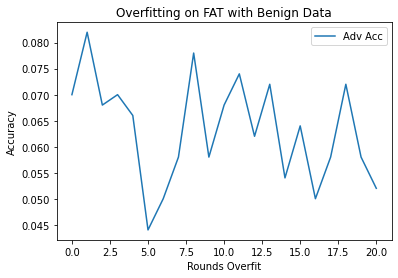

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


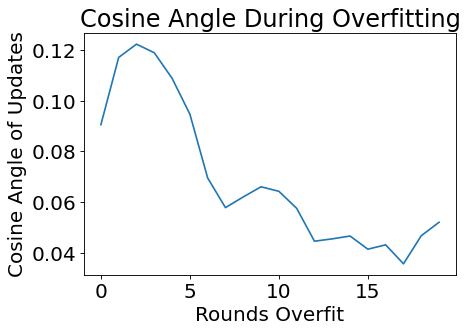

In [13]:
np.mean(cosine_gather_layers,axis = 1)

import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
y1 = np.mean(cosine_gather_layers,axis = 1)
x = range(len(y1))  # 100 points from 0 to 10


# Plotting the lines
plt.plot(x, y1)

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Cosine Angle of Updates')
plt.title('Cosine Angle During Overfitting')

# Adding a legend
# plt.legend()

# Display the plot
plt.show()


In [14]:
# print(x)
print(y1)
# print(y2)


[0.09 0.12 0.12 0.12 0.11 0.09 0.07 0.06 0.06 0.07 0.06 0.06 0.04 0.05
 0.05 0.04 0.04 0.04 0.05 0.05]


: 

Trial 1

[0.11 0.12 0.12 0.10 0.09 0.08 0.07 0.07 0.06 0.06 0.07 0.06 0.07 0.05
 0.06 0.05 0.06 0.06 0.07 0.06]
[0.3100000023841858, 0.27400001883506775, 0.3060000240802765, 0.25600001215934753, 0.25, 0.20400001108646393, 0.21000000834465027, 0.23000000417232513, 0.22600001096725464, 0.19200000166893005, 0.23600001633167267, 0.20000000298023224, 0.23600001633167267, 0.2800000011920929, 0.25, 0.20200000703334808, 0.21000000834465027, 0.23400001227855682, 0.2600000202655792, 0.23000000417232513, 0.1860000044107437]

In [ ]:
# Get number of params per desired key
size = np.zeros(len(desired_keys))
i = 0
for key in desired_keys:
    size[i]=params_FAT[key].flatten().shape[0]
    i += 1

prop = size/np.sum(size)

cosine_propped = np.zeros(cosine_gather_layers.shape)

# for t in range(num_rounds):
#     cosine_propped[t,:] = np.average(cosine_gather_layers[t,:], weights = prop)

np.average(cosine_gather_layers, weights = prop, axis = 1)

array([0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01, 0.01, 0.01, 0.00, 0.00,
       0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.01, 0.00, 0.00])

Text(0.5, 1.0, 'Per Layer Cosine Angle Round 1')

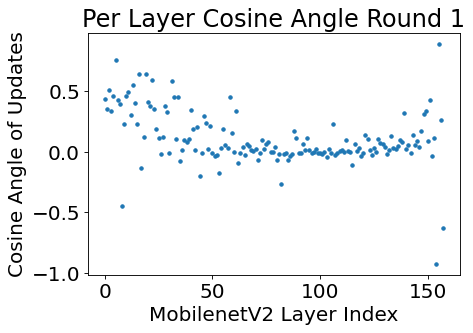

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plt.plot(cosine_gather_layers[0],'.')

# Adding labels and title
plt.xlabel('MobilenetV2 Layer Index')
plt.ylabel('Cosine Angle of Updates')
plt.title('Per Layer Cosine Angle Round 1')